In [1]:
import numpy as np
import matplotlib.pyplot as plt
def load_rbf_parameters(filepath='./TA16_RBF.par'):
    """
    Load RBF parameters from file, excluding the last 3 lines of statistics.
    
    Parameters:
    -----------
    filepath : str
        Path to the RBF parameter file
        
    Returns:
    --------
    numpy.ndarray
        Array of RBF parameters
    """
    with open(filepath, 'r') as f:
        # 读取所有行但排除最后三行
        lines = f.readlines()[:-3]
        
    # 转换为浮点数数组
    parameters = np.array([float(line.strip()) for line in lines])
    
    return parameters


def rbf_model_2016(iopt, parmod, ps, x, y, z):
    """
    Returns components of the external magnetic field vector (due to magnetospheric currents only,
    without contribution from Earth's sources), according to the data-based RBF-model driven by
    interplanetary and ground-based observables.

    Parameters:
    -----------
    iopt : int
        Dummy parameter included for compatibility with tracing software package
    parmod : array-like
        Array with first 4 elements specified as:
        - parmod[0] = PDYN: solar wind dynamic pressure in nPa
        - parmod[1] = <SymHc>: corrected SymH index
        - parmod[2] = <XIND>: solar-wind-magnetosphere coupling index
        - parmod[3] = <IMF BY>: azimuthal IMF By in nanoTeslas
    ps : float
        Geodipole tilt angle (in radians)
    x, y, z : float
        Cartesian GSW (or GSM) position (in Earth's radii, Re=6371.2km)

    Returns:
    --------
    tuple
        (BX, BY, BZ) - GSW (or GSM) components of the model field (nanoTesla)
    """
    # Constants
    D = 4.0
    PI = np.pi
    
    # Model parameters
    model_params = [
        12.544, -0.194, 0.305, 0.0573, 2.178,
        0.0571, -0.999, 16.473, 0.00152, 0.382,
        0.0431, -0.00763, -0.210, 0.0405, -4.430,
        -0.636, -2.600, 0.832, -5.328, 1.103,
        -0.907, 1.450
    ]
    (A0, A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, A11, A12, A13, A14, 
     A15, A16, A17, A18, A19, A20, A21) = model_params

    # Load RBF parameters
    try:
        A = load_rbf_parameters()
    except FileNotFoundError:
        raise FileNotFoundError("Required parameter file 'TA16_RBF.par' not found")

    # Grid parameters
    KLAT = 8  # number of latitude circles in northern hemisphere
    RLOW_GRID = 3.3  # innermost sphere radius
    RHIGH_GRID = 16.0  # upper limit on radius of outermost RBF sphere
    XGSW_LIM_DATA = -20.0  # upper limit on data tailward limit
    RH = 8.0  # hinging parameters
    ALPHA = 3.0  # alpha parameter


    def create_rbf_grid():
        """Create 3D Kurihara's grid of RBF centers"""
        XX, YY, ZZ = [], [], []
        ST, RHO, ZSP, ZCP, RHBR = [], [], [], [], []
        
        NLAT = KLAT + 1
        DLAT_DEG = 90.0 / (NLAT - 0.5)
        
        R = RLOW_GRID
        PD_TR = 0.5
        PM = 0.0
        BzIMF_TR = 0.0
        PSI = 0.0
        
        L = 0
        
        for _ in range(100):  # J counts number of spheres
            for I in range(1, NLAT + 1):
                XCOLATD = DLAT_DEG * (I - 1)
                NLON = 4 * (I - 1) if I != 1 else 1
                DLON_DEG = 360.0 / NLON if I != 1 else 0.0
                
                for K in range(1, NLON + 1):
                    XLOND = (K - 1) * DLON_DEG
                    XCOLAT = np.radians(XCOLATD)
                    XLON = np.radians(XLOND)
                    
                    XXXX = R * np.sin(XCOLAT) * np.cos(XLON)
                    YYYY = R * np.sin(XCOLAT) * np.sin(XLON)
                    ZZZZ = R * np.cos(XCOLAT)
                    
                    # Calculate distance to magnetopause
                    RM = calculate_magnetopause_distance(XXXX, YYYY, ZZZZ, PSI, PD_TR, PM, BzIMF_TR,
                                                       A0, A1, A2, A3, A4, A5, A6, A7, A8, A9,
                                                       A16, A17, A18, A19, A20, A21)
                    
                    if R > RM:
                        continue
                        
                    L += 1
                    XX.append(XXXX)
                    YY.append(YYYY)
                    ZZ.append(ZZZZ)
                    ST.append(np.sin(XCOLAT))
                    RHO.append(R * np.sin(XCOLAT))
                    ZSP.append(ZZZZ * np.sin(XLON))
                    ZCP.append(ZZZZ * np.cos(XLON))
                    RHBR.append(RH/R * (1.0 - (1.0 + (R/RH)**ALPHA)**(1.0/ALPHA)))
            
            R = R * (NLAT - 0.5 + PI/4.0)/(NLAT - 0.5 - PI/4.0)
            if R > RHIGH_GRID:
                break
                
        return np.array(XX), np.array(YY), np.array(ZZ), np.array(ST), \
               np.array(RHO), np.array(ZSP), np.array(ZCP), np.array(RHBR)

    def calculate_magnetopause_distance(x, y, z, psi, pd_tr, pm, bzimf_tr,
                                      a0, a1, a2, a3, a4, a5, a6, a7, a8, a9,
                                      a16, a17, a18, a19, a20, a21):
        """Calculate distance to the Lin et al. model magnetopause"""
        rho2 = y**2 + z**2
        r1 = np.sqrt(x**2 + rho2)
        rho1 = np.sqrt(rho2)
        
        if rho1 > 1e-5:
            sp = z/rho1
            cp = y/rho1
        else:
            if x > 0:
                sp = 0.0
                cp = 1.0
            else:
                return 1000.0
        
        ctt = x/r1
        stt = np.sqrt(rho2)/r1
        t = np.arctan2(stt, ctt)
        
        thetan = a19 + a20*psi
        thetas = a19 - a20*psi
        ctn = np.cos(thetan)
        cts = np.cos(thetas)
        stn = np.sin(thetan)
        sts = np.sin(thetas)
        
        psin = np.arccos(ctt*ctn + stt*stn*sp)
        psis = np.arccos(ctt*cts - stt*sts*sp)
        
        dn = a16 + (a17 + a18*psi)*psi
        ds = a16 - (a17 - a18*psi)*psi
        
        cn = 0.0
        cs = cn
        
        b0 = a6 + a7*(np.exp(a8*bzimf_tr)-1.0)/(np.exp(a9*bzimf_tr)+1.0)
        
        f1 = (np.sqrt(0.5*(1.+ctt)) + a5*2.0*stt*ctt*(1.0-np.exp(-t)))**b0
        r0 = a0*(pd_tr+pm)**a1*(1.0+a2*(np.exp(a3*bzimf_tr)-1.0)/(np.exp(a4*bzimf_tr)+1.0))
        
        return r0*f1 + cn*np.exp(dn*psin**a21) + cs*np.exp(ds*psis**a21)

    # Create RBF grid
    XX, YY, ZZ, ST, RHO, ZSP, ZCP, RHBR = create_rbf_grid()
    # Convert from GSW to SM coordinates
    XSM = x * np.cos(ps) - z * np.sin(ps)
    YSM = y
    ZSM = z * np.cos(ps) + x * np.sin(ps)
    
    # Get input parameters
    PDYN = parmod[0]
    SYMH = parmod[1]
    XIND = parmod[2]
    BYIMF = parmod[3]
    
    FPD = np.sqrt(PDYN/2.0) - 1.0
    SYMH = SYMH/50.0
    
    CPS = np.cos(ps)
    SPS = np.sin(ps)
    TPS = SPS/CPS
    
    # Initialize magnetic field components
    BXSM = BYSM = BZSM = 0.0
    
    # Calculate field components
    for i in range(len(XX)):
        XP, YP, ZP = XX[i], YY[i], ZZ[i]
        XM, YM, ZM = XP, YP, -ZP
        
        DELTA_ZR = RHBR[i] * TPS
        DTHETA = -np.arcsin(DELTA_ZR) * ST[i]
        SDT = np.sin(DTHETA)
        CDTM1 = np.cos(DTHETA) - 1.0
        
        # Calculate field contributions
        DXP = XP*CDTM1 + SDT*ZCP[i]
        DYP = YP*CDTM1 + SDT*ZSP[i]
        DZP = ZP*CDTM1 - RHO[i]*SDT
        DXM = XM*CDTM1 - SDT*ZCP[i]
        DYM = YM*CDTM1 - SDT*ZSP[i]
        DZM = ZM*CDTM1 - RHO[i]*SDT
        
        CP = np.sqrt((XSM-XP-DXP)**2 + (YSM-YP-DYP)**2 + (ZSM-ZP-DZP)**2 + D**2)
        CM = np.sqrt((XSM-XM-DXM)**2 + (YSM-YM-DYM)**2 + (ZSM-ZM-DZM)**2 + D**2)
        
        # Calculate derivatives
        DCPX = (XSM-XP-DXP)/CP
        DCMX = (XSM-XM-DXM)/CM
        DCPY = (YSM-YP-DYP)/CP
        DCMY = (YSM-YM-DYM)/CM
        DCPZ = (ZSM-ZP-DZP)/CP
        DCMZ = (ZSM-ZM-DZM)/CM
        
        # Calculate second derivatives
        DCPX2 = 1.0/CP - DCPX**2/CP
        DCMX2 = 1.0/CM - DCMX**2/CM
        DCPY2 = 1.0/CP - DCPY**2/CP
        DCMY2 = 1.0/CM - DCMY**2/CM
        DCPZ2 = 1.0/CP - DCPZ**2/CP
        DCMZ2 = 1.0/CM - DCMZ**2/CM
        
        DCPXY = -DCPX*DCPY/CP
        DCMXY = -DCMX*DCMY/CM
        DCPXZ = -DCPX*DCPZ/CP
        DCMXZ = -DCMX*DCMZ/CM
        DCPYZ = -DCPY*DCPZ/CP
        DCMYZ = -DCMY*DCMZ/CM
        
        # Calculate cross products and other terms
        TXCP = ZSM*DCPY - YSM*DCPZ
        TYCP = XSM*DCPZ - ZSM*DCPX
        TZCP = YSM*DCPX - XSM*DCPY
        TXCM = ZSM*DCMY - YSM*DCMZ
        TYCM = XSM*DCMZ - ZSM*DCMX
        TZCM = YSM*DCMX - XSM*DCMY
        
        PXCP = 2.0*DCPX - XSM*(DCPY2+DCPZ2) + YSM*DCPXY + ZSM*DCPXZ
        PYCP = 2.0*DCPY - YSM*(DCPX2+DCPZ2) + ZSM*DCPYZ + XSM*DCPXY
        PZCP = 2.0*DCPZ - ZSM*(DCPX2+DCPY2) + XSM*DCPXZ + YSM*DCPYZ
        PXCM = 2.0*DCMX - XSM*(DCMY2+DCMZ2) + YSM*DCMXY + ZSM*DCMXZ
        PYCM = 2.0*DCMY - YSM*(DCMX2+DCMZ2) + ZSM*DCMYZ + XSM*DCMXY
        PZCM = 2.0*DCMZ - ZSM*(DCMX2+DCMY2) + XSM*DCMXZ + YSM*DCMYZ
        
        CTX = CPS*(TXCP+TXCM)
        CTY = CPS*(TYCP+TYCM)
        CTZ = CPS*(TZCP+TZCM)
        
        STX = SPS*(TXCP-TXCM)
        STY = SPS*(TYCP-TYCM)
        STZ = SPS*(TZCP-TZCM)
        
        CPX = CPS*(PXCP-PXCM)
        CPY = CPS*(PYCP-PYCM)
        CPZ = CPS*(PZCP-PZCM)
        
        SPX = SPS*(PXCP+PXCM)
        SPY = SPS*(PYCP+PYCM)
        SPZ = SPS*(PZCP+PZCM)
        # Calculate total field components
        ACT = (A[i] + A[i+5184]*FPD + A[i+10368]*SYMH + A[i+15552]*XIND)
        AST = (A[i+1296] + A[i+6480]*FPD + A[i+11664]*SYMH + A[i+16848]*XIND)
        AT = A[i+20736]*BYIMF
        ACP = (A[i+2592] + A[i+7776]*FPD + A[i+12960]*SYMH + A[i+18144]*XIND)
        ASP = (A[i+3888] + A[i+9072]*FPD + A[i+14256]*SYMH + A[i+19440]*XIND)
        AP = A[i+22032]*BYIMF
        
        BXSM += (CTX*ACT + STX*AST + (TXCP-TXCM)*AT + CPX*ACP + SPX*ASP + 
                (PXCP+PXCM)*AP)
        BYSM += (CTY*ACT + STY*AST + (TYCP-TYCM)*AT + CPY*ACP + SPY*ASP + 
                (PYCP+PYCM)*AP)
        BZSM += (CTZ*ACT + STZ*AST + (TZCP-TZCM)*AT + CPZ*ACP + SPZ*ASP + 
                (PZCP+PZCM)*AP)
    
    # Convert magnetic field components back from SM to GSM (GSW) system
    BX = BXSM*CPS + BZSM*SPS
    BY = BYSM
    BZ = BZSM*CPS - BXSM*SPS
    
    return BX, BY, BZ

In [3]:
ta16_input = [-5.48,3.69,2.21,-448.6,-20.3,-12.0,5.45,22746,-14.0,1,1,-0.1075,2.13,0.1534,0.0234,-30.6]
parmod = [ta16_input[-4], ta16_input[-8], 1, ta16_input[1]] + [0] * 6
parmod = [2,13, -14, 1, 3.69] + [0] * 6
ps = 0
x, y, z = 3, 0, 0
iopt = 1
bx, by, bz = rbf_model_2016(iopt, parmod, ps, x, y, z)
print(f"bx={bx}, by={by}, bz={bz}")

bx=-0.039058784451650286, by=0.31072656219187267, bz=144.97977938287735


In [ ]:
from datetime import datetime
import spacepy as sp
import PyGeopack as gp
import re

year, month, day = 2021, 5, 16
t = datetime(year, month, day)
yday = t.timetuple().tm_yday
with open("./{}_OMNI_5m_with_RBF_TA16_drivers.dat".format(year), 'r') as f:
    lines = f.readlines()
pattern = rf"^{year}\s*0?{yday}\b"
incidents = [i for i in lines if re.match(pattern, i)]
incidents_array = np.array([[j for j in i.split(" ") if j.strip()] for i in incidents])
datetimes = []
bfields = []
for i in range(len(incidents_array)):
    incident_array = [float(j) for j in incidents_array[i]]
    (hour, minute, BxIMF, ByIMF, BzIMF, Vx, Vy, Vz, Np, T, SymH, IMF_flag, SW_flag, Tilt, Pdyn, N_index, B_index, SymHc) = incident_array[2:]
    time = datetime(year, month, day, int(hour), int(minute))
    datetimes.append(time)

    # - parmod[0] = PDYN: solar wind dynamic pressure in nPa
    # - parmod[1] = <SymHc>: corrected SymH index
    # - parmod[2] = <XIND>: solar-wind-magnetosphere coupling index
    # - parmod[3] = <IMF BY>: azimuthal IMF By in nanoTeslas
    parmod = [0] * 10
    parmod[0], parmod[1], parmod[2], parmod[3] = Pdyn, SymHc, N_index, ByIMF
    iopt = 1
    ps = 0
    x, y, z = 10, 0, 0
    bx_ra16, by_ra16, bz_ra16 = rbf_model_2016(iopt, parmod, ps, x, y, z)

    bx_igrf, by_igrf, bz_igrf = gp.ModelField(x, y, z, int(datetime.strftime(time, "%Y%m%d")), hour+minute/60, "IGRF", "SM", "SM", tilt=0)
    btot = np.array([bx_ra16+bx_igrf[0], by_ra16+by_igrf[0], bz_ra16+bz_igrf[0]])
    bfields.append(np.linalg.norm(btot))
    # print(bx_igrf, by_igrf, bz_igrf, btot)

[0.65876588] [-0.03459601] [30.3853138] [ 0.49305129 -0.43071031 55.42644893]
[0.65863485] [-0.03537024] [30.38593933] [ 0.49760147 -0.42029487 54.97464183]
[0.65544023] [-0.0508428] [30.3983306] [ 0.49908805 -0.42457776 55.14014858]
[0.6511739] [-0.06618533] [30.41042246] [ 0.49856667 -0.43096856 55.17746354]
[0.64460715] [-0.08450418] [30.42462607] [ 0.50885226 -0.40900459 55.90650062]
[0.63794925] [-0.09959675] [30.43615264] [ 0.5078118  -0.41066956 55.90783002]
[0.6268995] [-0.12028294] [30.45171787] [ 0.49208085 -0.44254542 56.23249845]
[0.61992802] [-0.13149926] [30.46005464] [ 0.48417313 -0.45599968 55.9434158 ]
[0.61473529] [-0.13918068] [30.46572559] [ 0.48272536 -0.45472935 55.45374879]
[0.60536872] [-0.15188005] [30.47503737] [ 0.4827212  -0.44504939 54.73450464]
[0.599499] [-0.15920948] [30.48037787] [ 0.49651254 -0.40538221 54.68295558]
[0.59334033] [-0.16646177] [30.48563956] [ 0.50158875 -0.38577929 54.71384681]
[0.58198362] [-0.17883502] [30.49456873] [ 0.50708437 -0.35

(0.0, 100.0)

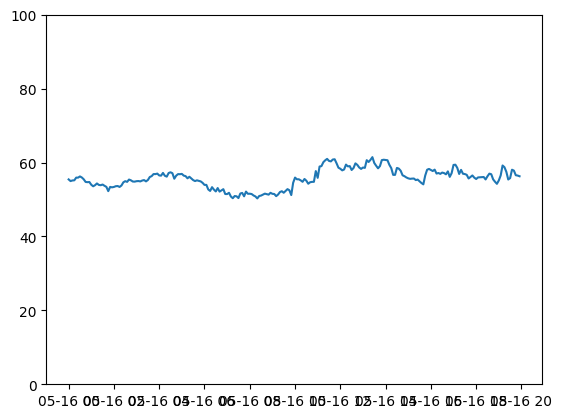

In [30]:
plt.plot(datetimes, bfields)
plt.ylim(0,100)
# plt.xlim(datetime(2021, 2, 16, 20), datetime(2021, 2, 16, 22))

In [29]:
def MAG(tilt, x, y, z):
    # 默认gsm坐标系下偶极场
    #  待添加其他模型
    PS = np.deg2rad(tilt)
    SPS = np.sin(PS)
    CPS = np.cos(PS)
    PSI = PS
    M = 1
    P = x ** 2
    U = z ** 2
    V = 3 * z * x
    T = y ** 2
    Q = 0.7 * 0.31E5 / np.sqrt(P + T + U) ** 5
    Bx = Q * ((T + U - 2 * P) * SPS - V * CPS)
    By = -3 * y * Q * (x * SPS + z * CPS)
    Bz = Q * ((P + T - 2 * U) * CPS - V * SPS)
    Bx = 0
    By = 0
    Bz = 0.311 * (np.sqrt(x**2 + y**2))**(-3) * 1e5
    return np.array([Bx, By, Bz])
MAG(0, 10, 0, 0)

array([ 0. ,  0. , 31.1])

In [85]:
gp.ModelField(x, y, z, int(datetime.strftime(time, "%Y%m%d")), hour+minute/60, "IGRF", "SM", "SM", tilt=0)

(array([9.34356042]), array([1.07186122]), array([245.97940625]))

In [89]:
gp.ModelField(x, y, z, int(datetime.strftime(time, "%Y%m%d")), hour+minute/60, "IGRF", "GSM", "GSM", tilt=0)

(array([63.89468589]), array([2.09112042]), array([243.58096746]))